In [1]:
import os
import glob
from datetime import datetime
from multiprocessing import Pool

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm

from cartopy.crs import LambertAzimuthalEqualArea
from cartopy.feature import LAND

from lmsiage.uncertainty import ComputeAgeUncertainty

srs_dst = LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)
%matplotlib inline

In [2]:
sia_dir = '../NERSC_arctic25km_sea_ice_age_v2p1/zarr'
mesh_dir = f'{sia_dir}/mesh'
age_dir = f'{sia_dir}/age'
unc_dir = f'{sia_dir}/uncert'


In [ ]:
from lmsiage.mesh_file import MeshFile


idate = datetime(1994, 12, 31)
n_fracs = 5

#idate = datetime(1995, 12, 31)
#n_fracs = 6
#idate = datetime(2024, 12, 31)
#n_fracs = 6

#oyear = '2024'

unc_file = idate.strftime(f'{unc_dir}/%Y/unc_%Y%m%d.zip')
self = ComputeAgeUncertainty(mesh_dir, age_dir, unc_dir, force=True)
mesh_file, age_file, unc_file = self.get_files(unc_file)
status = self.load_data(mesh_file, age_file, unc_file)
self.compute()

x, y, t = MeshFile(mesh_file).load(['x', 'y', 't'], as_dict=False)


unc_myi, unc_sid, unc_sic_sid = [
    [inp_dict[key] for key in sorted(inp_dict.keys(), reverse=True)]
    for inp_dict in [self.unc_myi, self.unc_sid, self.unc_sic_sid]
]



In [26]:
plt_sic = list(self.fracs[::-1])
plt_unc_myi = [self.unc_sic] + unc_myi
plt_unc_sid = [np.zeros_like(unc_sid[0])] + unc_sid
plt_unc_sic_sid = [np.zeros_like(unc_sic_sid[0])] + unc_sic_sid
plt_unc_sic = list(self.unc_fracs[::-1])

#plt_unc_myi = [np.hypot(self.unc_sic, unc_myi[0])] + [np.hypot(unc_myi[i], unc_myi[i+1]) for i in range(len(unc_myi)-1)] + [unc_myi[-1]]
#plt_unc_sic = [np.hypot(i, j) for (i, j) in zip(plt_unc_myi, plt_unc_sic_sid)]

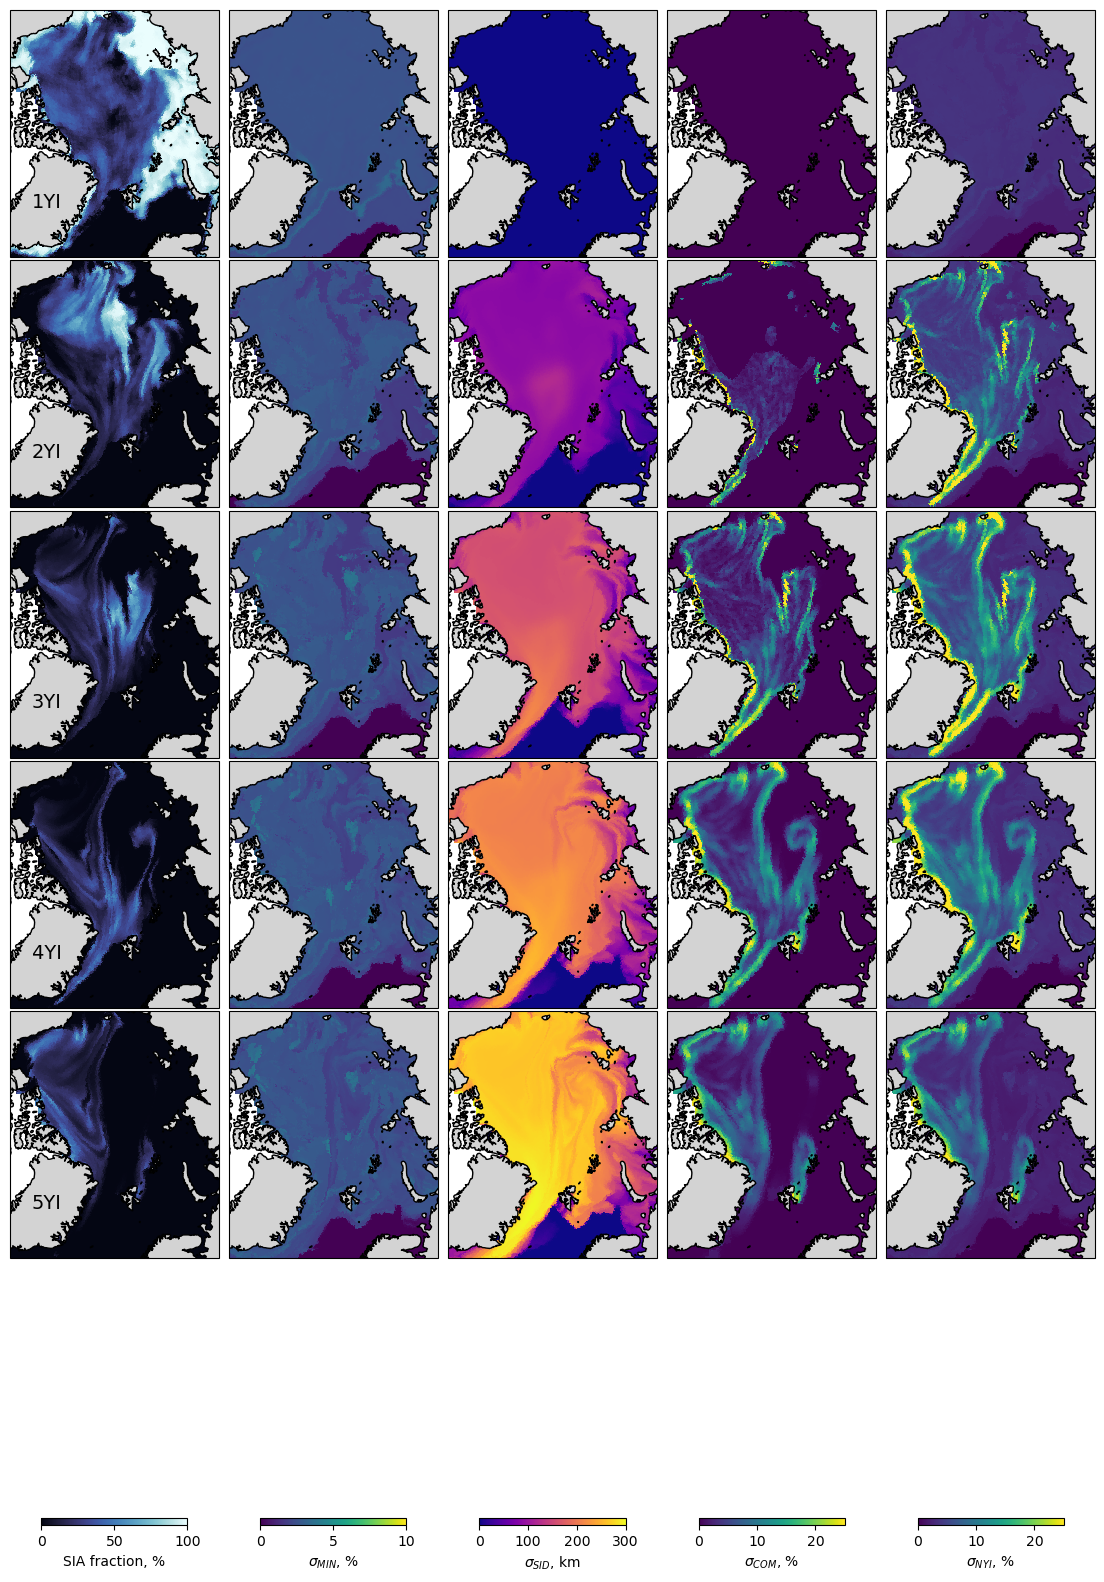

In [ ]:
fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(7, 5, height_ratios=[20, 20, 20, 20, 20, 20, 3])

clims = [
    [0, 100],  # SIA fraction
    [0, 10],   # SIC Uncertainty
    [0, 300],  # Drift Uncertainty
    [0, 25],   # SID Uncertainty
    [0, 25]    # Total Uncertainty
]

cmaps = [
    cm.ice,      # SIA fraction
    'viridis',   # SIC Uncertainty
    'plasma',    # Drift Uncertainty
    'viridis',   # SID Uncertainty
    'viridis'      # Total Uncertainty
]

cbar_labels = [
    'SIA fraction, %',
    '$\\sigma_{MIN}$, %',
    '$\\sigma_{SID}$, km',
    '$\\sigma_{COM}$, %',
    '$\\sigma_{NYI}$, %'
]

for row in range(n_fracs):
    arrays = [plt_sic[row], plt_unc_myi[row], plt_unc_sid[row], plt_unc_sic_sid[row], plt_unc_sic[row]]
    axs = []
    trps = []
    for col in range(5):
        ax = fig.add_subplot(gs[row, col], projection=srs_dst)
        trp = ax.tripcolor(x*1000, y*1000, t, arrays[col], clim=clims[col], cmap=cmaps[col])
        axs.append(ax)
        trps.append(trp)
    
    for ax in axs:
        ax.add_feature(LAND, facecolor='lightgray', edgecolor='black', zorder=1)
        ax.set_xlim([-1800000, 2000000])
        ax.set_ylim([-2300000, 2200000])
    axs[0].text(-1400000, -1400000, f'{row+1}YI', fontsize=14, zorder=2)

for col in range(5):
    ax_cbar = fig.add_subplot(gs[6, col])
    ax_cbar.set_visible(False)
    cbar0 = fig.colorbar(trps[col], ax=ax_cbar, orientation='horizontal', fraction=0.8, shrink=0.7)
    cbar0.set_label(cbar_labels[col])

plt.subplots_adjust(hspace=0, wspace=0.05)
#plt.savefig(f'figure08_uncertainty_maps_{oyear}.png', bbox_inches='tight', dpi=150, pad_inches=0.1)
plt.show()